# Autoencoders for image denoising

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)
3. [Predict using the autoencoder](#predict)
3. [Denoising using the autoencoder](#denoise)

In [22]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory

from utils.image import preprocess, noise, display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [26]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NOISE_FACTOR = 0.4
Z_DIM = 16
EPOCHS = 1

## 1. Prepare the data <a name="prepare"></a>

In [3]:
train_data = image_dataset_from_directory(
    "../../data/lego/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "../../data/lego/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.
Using 32000 files for training.
Found 40000 files belonging to 1 classes.
Using 8000 files for validation.


In [4]:
train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

In [5]:
train_sample = sample_batch(train)
test_sample = sample_batch(test)

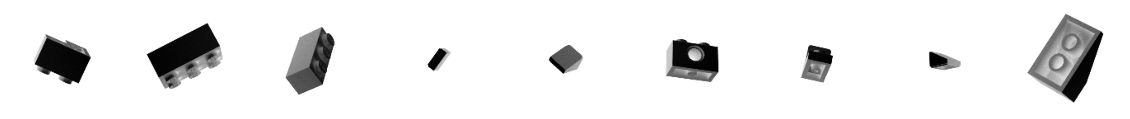

In [6]:
display(train_sample)

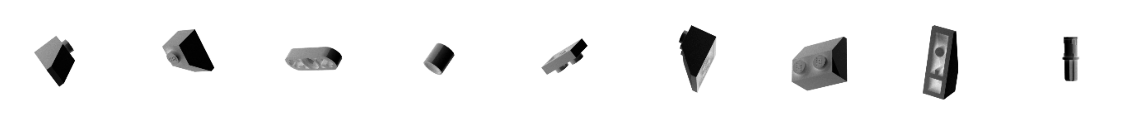

In [7]:
display(test_sample)

In [8]:
noisy_train = train.map(lambda x: noise(x, NOISE_FACTOR))
noisy_test = test.map(lambda x: noise(x, NOISE_FACTOR))

noisy_train_sample = np.array([noise(x, NOISE_FACTOR) for x in train_sample])
noisy_test_sample = np.array([noise(x, NOISE_FACTOR) for x in test_sample])

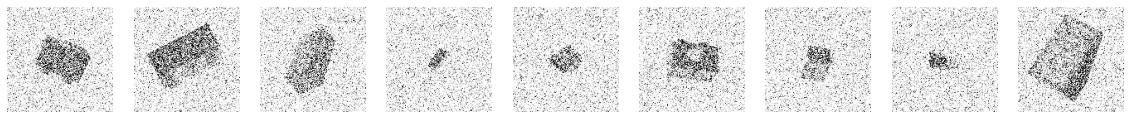

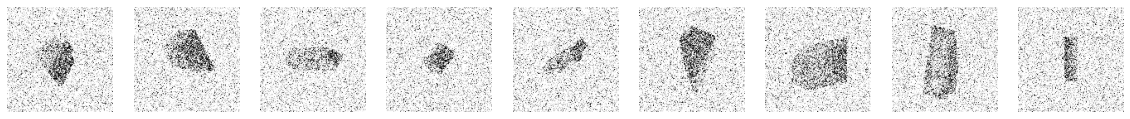

In [9]:
display(noisy_train_sample)
display(noisy_test_sample)

## 2. Build the autoencoder <a name="build"></a>

In [35]:
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", strides = 2, padding="same")(encoder_input)
x = layers.Conv2D(32, (3, 3), activation="relu", strides = 2, padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", strides = 2, padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", strides = 2, padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", strides = 2, padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", strides = 2, padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(Z_DIM, name="encoder_output")(x)

# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
encoder = Model(encoder_input, encoder_output)
decoder = Model(decoder_input, decoder_output)
autoencoder = Model(encoder_input, decoder(encoder_output))

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_58 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_61 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 conv2d_62 (Conv2D)          (None, 4, 4, 32)          9248      
                                                                 
 conv2d_63 (Conv2D)          (None, 2, 2, 32)          924

## 3. Train the autoencoder <a name="train"></a>

In [ ]:
train_in = train.map(lambda x : (x, x))
test_in = test.map(lambda x : (x, x))

history = autoencoder.fit(
    train_in,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=test_in,
)

 445/1000 [============>.................] - ETA: 4:32 - loss: 0.1703

## 4. Predict using the autoencoder <a name="train"></a>

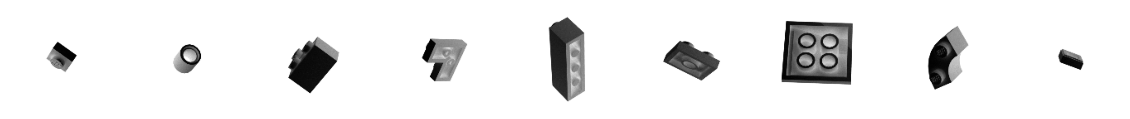

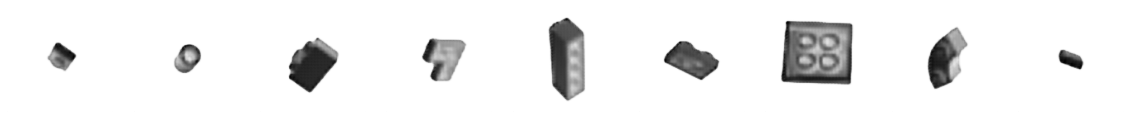

In [55]:
predictions = autoencoder.predict(test_sample)
display(test_sample)
display(predictions)

## 5. Denoise using the autoencoder <a name="denoise"></a>

In [16]:
noisy_train_in = noisy_train.map(lambda x : (x, x))
noisy_test_in = noisy_test.map(lambda x : (x, x))

In [17]:
history = autoencoder.fit(
    noisy_train_in,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=noisy_test_in,
)

  38/1000 [>.............................] - ETA: 9:42 - loss: 0.5887

KeyboardInterrupt: 

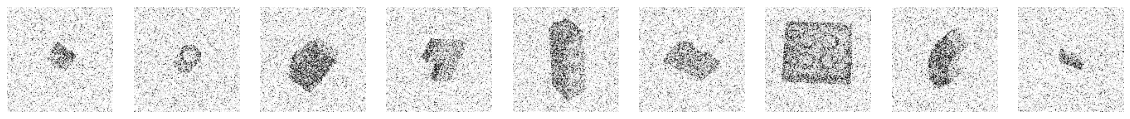

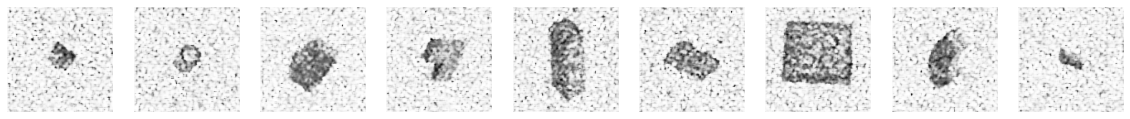

In [64]:
predictions = autoencoder.predict(noisy_test_sample)
display(noisy_test_sample)
display(predictions)